In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import math
import json

import istarmap  # import to apply monkey patch to multiprocess
import multiprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats 
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler, RobustScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

from aggregators import bucket_and_bin

In [3]:
# ouputs
fn_distance = '../data/output/figs/fig2_dist.csv'
fn_t_test = '../data/output/tables/table1_cities_ranked_by_categories.csv'
fn_regression_all = '../data/output/tables/table2_regression_outputs_all.csv'
fn_regression_income = '../data/output/tables/table3a_regression_outputs_income.csv'
fn_regression_race = '../data/output/tables/table3b_regression_outputs_race.csv'
fn_regression_redlining = '../data/output/tables/table3c_regression_outputs_redlining.csv'


fn_observed_income = '../data/output/figs/fig4_income.csv'
fn_adjusted_income = '../data/output/figs/fig5_income.csv'
fn_observed_race = '../data/output/figs/fig4_race.csv'
fn_adjusted_race= '../data/output/figs/fig5_race.csv'
fn_observed_redlining = '../data/output/figs/fig4_redlining.csv'
fn_adjusted_redlining = '../data/output/figs/fig5_redlining.csv'

# inputs
fn_att = '../data/output/speed_price_att.csv.gz'
fn_centurylink = '../data/output/speed_price_centurylink.csv.gz'
fn_verizon = '../data/output/speed_price_verizon.csv.gz'
fn_earthlink = '../data/output/speed_price_earthlink.csv.gz'
inputs = {
    "AT&T" : fn_att,
    "CenturyLink": fn_centurylink,
    "Verizon": fn_verizon,
    "EarthLink" : fn_earthlink
}

# params
recalculate = False
n_jobs = 10

In [4]:
def filter_df(fn, isp):
    """
    Filters out no service offers, and cities which we can't analyze
    """
    df = pd.read_csv(fn)
    df = df[df.speed_down != 0]
    df = bucket_and_bin(df)
    df['isp'] = isp
    if isp == 'Verizon':
        df.price = df.price.replace({40: 39.99, 49.99: 39.99})
        df = df[df.price == 39.99]
        nyc_cities = ['new york', 'brooklyn', 'queens', 'staten island', 'brooklyn', 'bronx']
        nyc = []
        for city, _df in df.groupby('major_city'):
            if city in nyc_cities:
                nyc.extend(_df.to_dict(orient='records'))
        nyc = pd.DataFrame(nyc)
        nyc['major_city'] = 'new york city'
        
        # add NYC
        df = df[~df.major_city.isin(nyc_cities)]
        df = df.append(nyc)
        
    elif isp == 'EarthLink':
        df = df[df.contract_provider.isin(['AT&T', 'CenturyLink'])]
    # filter out cities that don't have variety of speeds
#     variety = df.groupby(['major_city', 'state']).speed_down_bins.value_counts(normalize=True)
#     homogenous_cities = set(variety[variety >= .95].index.get_level_values(0))
    homogenous_cities = set()
    homogenous_cities.add('bridgeport') # just four offers from non-frontier
    df = df[~df.major_city.isin(homogenous_cities)]
    return df

In [5]:
c = 0
cities = set()
for (isp, fn) in inputs.items():
    d = filter_df(fn, isp=isp)
    cities.update(d.major_city.unique())
    c += len(d)
    print(f"{isp} we analyzed {len(d)} addresses from {d.major_city.nunique()} cities")
c, len(cities)

AT&T we analyzed 343591 addresses from 20 cities


<ipython-input-5-9af7006426e1>:4: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  d = filter_df(fn, isp=isp)


CenturyLink we analyzed 180067 addresses from 15 cities


<ipython-input-5-9af7006426e1>:4: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  d = filter_df(fn, isp=isp)


Verizon we analyzed 224084 addresses from 9 cities
EarthLink we analyzed 390693 addresses from 33 cities


(1138435, 44)

## Median Distance

In [6]:
isp2house = {
    'Verizon': '../data/output/figs/house_emoji_brick.png',
    'AT&T': '../data/output/figs/house_emoji.png',
    'CenturyLink': '../data/output/figs/house_emoji_blue.png'
}

In [7]:
cols = [
    'address_full',
    'lat', 'lon',
    'race_perc_non_white',
    'n_providers',
    'median_household_income',
    'redlining_grade'
]
def plot_distance_to_fiber(slow_to_blazin, isp):
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label, markerfacecolor="#1f66e0", markersize=10)
                   for label, c in isp2house.items()][::-1]
    slow_to_blazin.major_city = slow_to_blazin.major_city.apply(lambda x: x.title())
    to_plot = slow_to_blazin.groupby(['major_city', 'state', 'isp']).closest_fiber_miles.median().sort_values(ascending=True)
    to_plot = (to_plot * 1609.34).reset_index()
    to_plot['zeros'] = 0
    print(to_plot.head(3))
    title = f"Median Distance Between Households {isp}\nOffered Slow Speeds and Blazin' Fiber Speeds"
    ax = to_plot.plot(x = 'closest_fiber_miles', y='major_city', kind='scatter',
                 s= 90, color ='#4385f2', figsize=(6, 10),
                 title=title)
    to_plot.plot(x = 'closest_fiber_miles', y='major_city', kind='scatter',
                 s= 20, color ='white', ax=ax)
    for i, (_, row) in enumerate(to_plot.iterrows()):
        x = row['closest_fiber_miles']
        fn_image = isp2house.get(row['isp'])
        image = OffsetImage(plt.imread(fn_image), zoom=.035)
        ab = AnnotationBbox(image, (x, i), frameon=False)
        ax.add_artist(ab)
    
    x1 = np.zeros(len(to_plot)).tolist()
    x2 = to_plot['closest_fiber_miles'].tolist()
    n = to_plot['major_city'].tolist()
    for i in range(0, len(x1)):
        plt.plot([x1[i], x2[i]], [n[i], n[i]], '-', color='#4385f2', lw=4, zorder=-1)

    # Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(left=0)
    labels = ax.get_xticks().tolist()
    labels = [int(_) for _ in labels]
    labels[0] = "0 meters"
    ax.set_xticklabels(labels)
    
    plt.gca().invert_yaxis()

    ax.set_xlabel("")
    ax.set_ylabel("")
#     ax.get_legend().remove()
    
    ax.grid(axis='x', zorder=0)
    ax.set_ylim(top=n[0], bottom=n[-1])
    plt.show()

In [8]:
slows_to_blazins = pd.DataFrame([])
for isp, fn in inputs.items():
    if isp == 'EarthLink': continue
    df = filter_df(fn, isp)
    for city, _df in df.groupby(['major_city']):
        n_slow = len(_df[_df.speed_down_bins == 'Slow (<25 Mbps)'])
        n_not_slow = len(_df[_df.speed_down_bins != 'Slow (<25 Mbps)'])
        n_all = len(_df)
        if (_df.speed_down_bins.nunique() <= 1) or (n_slow / n_all <= .01) or (n_not_slow / n_all <= .01):
            continue
        slow_to_blazin = _df[(_df.closest_fiber_miles != 0) & 
                            (_df.speed_down <= 25)]
        slows_to_blazins = slows_to_blazins.append(slow_to_blazin)

<ipython-input-8-d3891d53ddcc>:4: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  df = filter_df(fn, isp)
<ipython-input-8-d3891d53ddcc>:4: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  df = filter_df(fn, isp)


     major_city state      isp  closest_fiber_miles  zeros
0  Philadelphia    PA  Verizon            35.585935      0
1        Boston    MA  Verizon            53.643582      0
2    Washington    DC  Verizon            75.804138      0


<ipython-input-7-3194b9122f6e>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


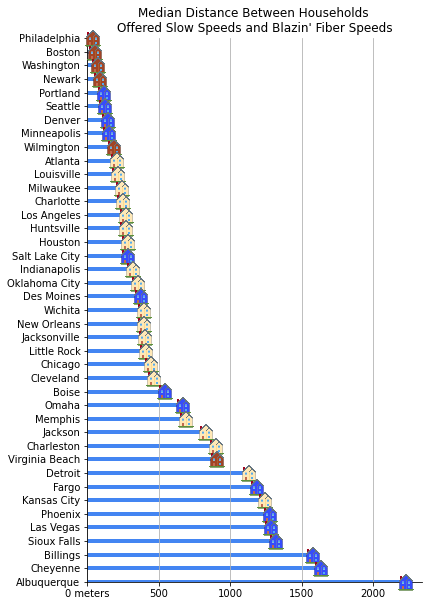

In [9]:
plot_distance_to_fiber(slows_to_blazins, isp="")

In [10]:
dist_summary = slows_to_blazins.groupby(['major_city', 'state', 'isp']).closest_fiber_miles.median().sort_values(ascending=True)

In [11]:
dist_summary.to_csv(fn_distance)

In [12]:
slows_to_blazins.groupby('isp').closest_fiber_miles.median().sort_values(ascending=True)* 1609.34

isp
Verizon        124.110743
AT&T           415.118421
CenturyLink    659.793897
Name: closest_fiber_miles, dtype: float64

In [13]:
dist_summary * 1609.34

major_city      state  isp        
Philadelphia    PA     Verizon          35.585935
Boston          MA     Verizon          53.643582
Washington      DC     Verizon          75.804138
Newark          NJ     Verizon          87.506333
Portland        OR     CenturyLink     117.594082
Seattle         WA     CenturyLink     121.755967
Denver          CO     CenturyLink     146.930425
Minneapolis     MN     CenturyLink     148.974406
Wilmington      DE     Verizon         188.670832
Atlanta         GA     AT&T            206.139991
Louisville      KY     AT&T            217.147994
Milwaukee       WI     AT&T            239.148902
Charlotte       NC     AT&T            246.165900
Los Angeles     CA     AT&T            269.980644
Huntsville      AL     AT&T            270.237510
Houston         TX     AT&T            281.306554
Salt Lake City  UT     CenturyLink     283.378684
Indianapolis    IN     AT&T            319.762967
Oklahoma City   OK     AT&T            356.592321
Des Moines     

In [14]:
def which_has_largest_proportion(df, col='income_level', bins=['Low'], comparison=[]):
    sample1 = df[df[col].isin(bins)]
    if len(comparison) != 0:
        sample2 = df[df[col].isin(comparison)]
    else:
        sample2 = df[~df[col].isin(bins)]
    try:
        prop1 = len(sample1[sample1.is_slow == 1]) / len(sample1)
        prop2 = len(sample2[sample2.is_slow == 1]) / len(sample2)
        return prop1, prop2, prop1 - prop2 > .05
    except Exception as e:
        print(e, df.head(2))
        return None, None, None

def test_flow(df, params):
    iv = params['iv']
    data = []
    for (city, state), _df in df.groupby(['major_city', 'state']):
        n_slow = len(_df[_df.is_slow == True])
        n_not_slow = len(_df[_df.is_slow == False])
        n_all = len(_df)
        
        variety = _df.speed_down_bins.value_counts(normalize=True)
        variety[variety >= .95]
        
        if len(variety[variety >= .95]) != 0:
            # skip cities with homogenous speed (this is just for EarthLink and Verizon)
            data.append({'major_city': city, 'state': state, 'isp': isp,
                         f'prop_slow_{iv}_exposure': None,
                         f'prop_slow_{iv}_treatment': None,
                         f'prop_slow_{iv}_delta' : None,
                         'flag': 'monospeed'})
            continue
        if iv == 'income':
            a, b, is_larger = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                           comparison=params['comparison'])

        elif iv == 'redlining':
            _df_rated = _df[~_df.redlining_grade.isnull()]
            if len(_df_rated) / n_all <= .05:
                data.append({'major_city': city, 'state': state, 'isp': isp,
                         f'prop_slow_{iv}_exposure': None,
                         f'prop_slow_{iv}_treatment': None,
                         f'prop_slow_{iv}_delta' : None,
                           'flag': 'not HOLC graded'})
                continue
            a, b, is_larger = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                           comparison=params['comparison'])
        elif iv == 'race':
            n_minority_white = len(_df[_df.race_perc_non_white > .50]) 
            # check only cities with at least 5 percent of addresses in minority white.
            if (n_minority_white / n_all <= .05):# or (n_majority_white / n_all <=.05):
                data.append({'major_city': city, 'state': state, 'isp': isp,
                         f'prop_slow_{iv}_exposure': None,
                         f'prop_slow_{iv}_treatment': None,
                         f'prop_slow_{iv}_delta' : None,
                          'flag' : 'no diversity'})
                continue
            a, b, is_larger = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                          comparison=params['comparison'])

        data.append({
            'major_city': city,
            'state': state,
            f'slowest_{iv}' : is_larger,
            'isp': isp,
            f'prop_slow_{iv}_exposure': a,
            f'prop_slow_{iv}_treatment': b,
            f'prop_slow_{iv}_delta' : a-b if a else None,
            'flag': None
        })
        
    return data

In [15]:
income_params = {'iv': "income", 'grades': ['Low'], 'col': 'income_level'}
race_params = {'iv': "race", 'grades': ['least white'], 'col': 'race_quantile'}
redlining_params = {'iv': "redlining", 'grades': ['D'], 'col': 'redlining_grade'}

# Treatment group
income_params['comparison'] = ['Upper Income']
race_params['comparison'] = ['most white']
redlining_params['comparison'] = ['A', 'B']

In [16]:
if not os.path.exists(fn_t_test) or recalculate:
    table = pd.DataFrame()
    for isp, fn in tqdm(inputs.items()):
        df = filter_df(fn, isp)
        income_data = test_flow(df, params=income_params)
        race_data = test_flow(df, params=race_params)
        redlining_data = test_flow(df, params=redlining_params)

        df_table = pd.DataFrame(income_data).merge(
            pd.DataFrame(race_data), on=['major_city', 'isp', 'state'], how='outer'
        ).merge(
            pd.DataFrame(redlining_data), on=['major_city', 'isp', 'state'], how='outer'
        )

        table = table.append(df_table)
    table.major_city = table.major_city.str.title()
    table.to_csv(fn_t_test, index=False)

else:
    table = pd.read_csv(fn_t_test)

In [17]:
# all cities in the study
n_cities = table.major_city.nunique()
n_cities

44

In [18]:
trend = set(table[(table.slowest_income == True) | 
      (table.slowest_race == True) | 
      (table.slowest_redlining == True)].major_city.unique())

reverse_trend = set(table[(table.slowest_income == False) & 
      (table.slowest_race == False) & 
      (table.slowest_redlining == False)].major_city.unique())

In [19]:
len(trend) / n_cities

0.8636363636363636

In [20]:
# how many cities exhibit none of these trends?
set(table.major_city.unique()) - trend

{'Albuquerque',
 'Baltimore',
 'Boston',
 'New York City',
 'Philadelphia',
 'Providence'}

In [21]:
random.seed(303)
summary_data = []
for isp in inputs.keys():
    table_ = table[table.isp == isp]
    display(Markdown(f"{isp} was significantly more likely to offer slow speeds in..."))
    
    if isp == 'EarthLink':
        table_['major_city'] = table_.apply(lambda x: f"{x['major_city']} ({x['state'].upper()})", axis=1)
        
    null_cities = table_[(table_.slowest_income.isnull()) | (table_.prop_slow_income_treatment == 0)].major_city.unique()
    all_cities = table_.major_city.nunique()
    all_cities -= len(null_cities)
    
    # income
    n_cities = table_[~table_.slowest_income.isnull()].major_city.nunique()
    cities = table_[table_.slowest_income == True].major_city.unique()
    sig_opposite_cities = table_[table_.slowest_income == False].major_city.unique()
    
    random.shuffle(cities)
    n_low = len(cities)
    
    record_income ={
        'isp': isp,
        'null_cities' : null_cities.tolist(),
        'all_cities' : all_cities,
        'income_cities' : table_[~table_.slowest_income.isnull()].major_city.nunique(),
        'income_percent_low_income': round(n_low / n_cities * 100, 1),
        'income_cities_significant': cities.tolist(),
        'income_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    
    text =  (
        f"- {' and '.join(income_params['grades'])} Income areas than Upper Income areas in **{round(n_low / n_cities * 100, 1)}**% of cities ({n_low})."
        f"<br>This includes cities like {cities[0].title()}, {cities[1].title()}, and {cities[2].title()}."
    )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was in {perc}% of cities ({len(sig_opposite_cities)})."

    display(Markdown(text))

    # race
    n_cities = table_[~table_.slowest_race.isnull()].major_city.nunique()
    random.shuffle(cities)
    cities = table_[table_.slowest_race == True].major_city.unique()
    
    sig_opposite_cities = table_[table_.slowest_race == False].major_city.unique()
    
    random.shuffle(cities)
    n_minority_white = len(cities)
    
    record_race ={
        'isp': isp,
        'race_cities' : table_[~table_.slowest_race.isnull()].major_city.unique().tolist(),
        'race_percent_low_income': round(n_minority_white / n_cities * 100, 1),
        'race_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    
    text = (
        f"- the {' and '.join(race_params['grades'])} areas compared to the most white areas in <b>{round(n_minority_white / n_cities * 100, 1)}</b>% of cities ({n_minority_white})."
        f"<br>This includes cities like {', '.join([c.title() for c in cities[:3]])}.\n"
    )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was in {perc}% of cities ({len(sig_opposite_cities)})."
 
    
    if n_cities < all_cities:
        diff = all_cities - n_cities
        record_race['race_n_cities_cant_analyze'] = diff
        text += f"<br>We exclude {diff} {'cities' if diff > 1 else 'city'} for not containing enough minority white areas for comparison."
    display(Markdown(text))

    # redlining
    n_cities = table_[~table_.slowest_redlining.isnull()].major_city.nunique()
    cities = table_[table_.slowest_redlining == True].major_city.unique()
    sig_opposite_cities = table_[table_.slowest_redlining == False].major_city.unique()
    random.shuffle(cities)
    n_redline = len(cities)
    
    record_redlining ={
        'isp': isp,
        'redline_cities' : table_[~table_.slowest_redlining.isnull()].major_city.unique().tolist(),
        'redline_percent_low_income': round(n_redline / n_cities * 100, 1),
        'redline_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    summary_data.append({**record_income, **record_race, **record_redlining})
    
    if len(cities) >= 3:
        text = (
            f"- {' and '.join(redlining_params['grades'])}"
            f" graded areas than A and B graded areas in **{round(n_redline/ n_cities * 100, 1)}**% of cities ({n_redline})."
            f"<br>This includes cities like {cities[0].title()}, {cities[1].title()}, and {cities[2].title()}."
        )
    else:
        text = (
            f"- {' and '.join(redlining_params['grades'])}"
            f" graded areas than better graded areas in **{round(n_redline/ n_cities * 100, 1)}**% of cities ({n_redline})."
            f"<br>This includes cities like {cities[0].title()}."
        )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was statistically significant in {perc}% of cities ({len(sig_opposite_cities)})."
    
    if n_cities < all_cities:
        diff = all_cities - n_cities
        record_redlining['redline_n_cities_cant_analyze'] = diff
        text += f"<br>We exclude {diff} {'cities' if diff > 1 else 'city'} for not containing enough HOLC graded areas for comparison."
    display(Markdown(text))

    if len(null_cities) > 0:
        n_null = len(null_cities)
        if n_null == 1:
            text = f"Note: {null_cities[0].title()} was only offered slow speeds. We exclude this city from the above calculations."
        else:
            text =(
                f"Note: we exclude {n_null} {'cities' if n_null > 1 else 'city'} that are served the same speed."
                f" This includes {', '.join([c.title() for c in null_cities[:3]])}."
            )
        display(Markdown(text))
    
    display(Markdown('<hr>'))

AT&T was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **100.0**% of cities (20).<br>This includes cities like Chicago, Los Angeles, and Kansas City.

- the least white areas compared to the most white areas in <b>75.0</b>% of cities (15).<br>This includes cities like Jacksonville, Little Rock, Charlotte.
<br>The opposite trend was in 25.0% of cities (5).

- D graded areas than A and B graded areas in **100.0**% of cities (16).<br>This includes cities like Milwaukee, Little Rock, and Atlanta.<br>We exclude 4 cities for not containing enough HOLC graded areas for comparison.

<hr>

CenturyLink was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **86.7**% of cities (13).<br>This includes cities like Boise, Omaha, and Fargo.<br>The opposite trend was in 13.3% of cities (2).

- the least white areas compared to the most white areas in <b>72.7</b>% of cities (8).<br>This includes cities like Des Moines, Omaha, Seattle.
<br>The opposite trend was in 27.3% of cities (3).<br>We exclude 4 cities for not containing enough minority white areas for comparison.

- D graded areas than A and B graded areas in **100.0**% of cities (8).<br>This includes cities like Salt Lake City, Seattle, and Minneapolis.<br>We exclude 7 cities for not containing enough HOLC graded areas for comparison.

<hr>

Verizon was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **100.0**% of cities (4).<br>This includes cities like Wilmington, Washington, and Virginia Beach.

- the least white areas compared to the most white areas in <b>66.7</b>% of cities (2).<br>This includes cities like Newark, Wilmington.
<br>The opposite trend was in 33.3% of cities (1).<br>We exclude 1 city for not containing enough minority white areas for comparison.

- D graded areas than better graded areas in **100.0**% of cities (1).<br>This includes cities like Newark.<br>We exclude 3 cities for not containing enough HOLC graded areas for comparison.

Note: we exclude 5 cities that are served the same speed. This includes Baltimore, Boston, New York City.

<hr>

EarthLink was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **89.5**% of cities (17).<br>This includes cities like Charlotte (Nc), New Orleans (La), and Little Rock (Ar).<br>The opposite trend was in 10.5% of cities (2).

- the least white areas compared to the most white areas in <b>52.6</b>% of cities (10).<br>This includes cities like Oklahoma City (Ok), Chicago (Il), Indianapolis (In).
<br>The opposite trend was in 47.4% of cities (9).

- D graded areas than A and B graded areas in **100.0**% of cities (15).<br>This includes cities like Kansas City (Mo), Cleveland (Oh), and Memphis (Tn).<br>We exclude 4 cities for not containing enough HOLC graded areas for comparison.

Note: we exclude 14 cities that are served the same speed. This includes Albuquerque (Nm), Billings (Mt), Boise (Id).

<hr>

### What patterns emerge when we collapose the ISPs together, and look at cities?

In [22]:
income_cities = table[~table.slowest_income.isnull()].major_city.unique()
race_cities = table[~table.slowest_race.isnull()].major_city.unique()
redlining_cities = table[~table.slowest_redlining.isnull()].major_city.unique()

In [23]:
all_cities = table[~table.slowest_income.isnull()].major_city.nunique()

In [24]:
for params in [income_params, race_params ,redlining_params]:
    iv = params['iv']
    base_group = params['grades'][0]
    
    # filter out cases we omitted for lack of data
    null = table[table[f'slowest_{iv}'].isnull()]
    null_city =  (set(table[table[f'slowest_{iv}'].isnull()].major_city.unique()) -
                     set(table[~table[f'slowest_{iv}'].isnull()].major_city))
    all_sig = table[~table[f'slowest_{iv}'].isnull()]
    all_cities_tested = all_sig.major_city.nunique()
#     homogenous = table[(table[f'prop_slow_{iv}_exposure'] == 0) | (table[f'prop_slow_{iv}_treatment'] == 0)]
    
    table_ = table[(table[f'prop_slow_{iv}_exposure'] != 0) & 
                   (table[f'prop_slow_{iv}_treatment'] != 0)]
    
    # of significant cases, when is the slowest class the lower income/least white/redlined example
    slowest = all_sig[all_sig[f"slowest_{iv}"] == True]
    perc_slower= len(slowest)
    perc_slower_city = slowest.major_city.nunique()
    print(f"{iv.title()} {len(all_sig)} city-ISP pairs and {all_cities_tested} cities"
          f"\n - {base_group} areas disproportionately offered slow speeds {perc_slower} city-isp pairs and {perc_slower_city} cities."
          f"\n - omit {len(null)} city-isp-pairs and {len(null_city)} cities. \n{null_city}")

Income 58 city-ISP pairs and 39 cities
 - Low areas disproportionately offered slow speeds 54 city-isp pairs and 37 cities.
 - omit 19 city-isp-pairs and 5 cities. 
{'Boston', 'Providence', 'Philadelphia', 'Baltimore', 'New York City'}
Race 53 city-ISP pairs and 34 cities
 - least white areas disproportionately offered slow speeds 35 city-isp pairs and 26 cities.
 - omit 24 city-isp-pairs and 10 cities. 
{'Boston', 'Providence', 'Billings', 'Philadelphia', 'Fargo', 'Baltimore', 'Boise', 'New York City', 'Virginia Beach', 'Cheyenne'}
Redlining 40 city-ISP pairs and 25 cities
 - D areas disproportionately offered slow speeds 40 city-isp pairs and 25 cities.
 - omit 37 city-isp-pairs and 19 cities. 
{'Sioux Falls', 'Charleston', 'Boise', 'Jacksonville', 'Albuquerque', 'Wilmington', 'Philadelphia', 'New York City', 'Virginia Beach', 'Las Vegas', 'Providence', 'Washington', 'Baltimore', 'Boston', 'Billings', 'Fargo', 'Huntsville', 'Oklahoma City', 'Cheyenne'}


In [25]:
color_1 = '#4f0d70'
color_2 = "#C31B6A"

bool2alpha = {
    True: .95,
    False : .35
}

In [26]:
def asterix_city(row, iv='income'):
    if row['flag'] == 'monospeed':
        return row['major_city'] + '*'
    if iv == 'redlining':
        if row['flag'] == 'not HOLC graded':
            return row['major_city'] + '˟'
    if iv == 'race':
        if row['flag_y'] == 'no diversity':
            return row['major_city'] + '˟'
    return row['major_city']

def plot_observed(to_plot, iv='income', fn=None, title=None, ylim=60.5):
    to_plot['Observed'] = to_plot[f'prop_slow_{iv}_delta']
#     to_plot_ = to_plot[~to_plot['Observed'].isnull()].copy()
    to_plot_ = to_plot.copy()
    to_plot_.sort_values(by=['isp', 'Observed'], ascending=[True, False], inplace=True)
    to_plot_['display_city'] = to_plot_.apply(asterix_city, axis=1, iv=iv)
    for col in ['Observed', f'prop_slow_{iv}_exposure', f'prop_slow_{iv}_treatment']:
        to_plot_[col] = to_plot_[col] * 100
    
    to_plot_['major_city_isp'] = to_plot_.apply(lambda x: x['isp'] + ' - ' + x['display_city'], axis=1)

    ax = to_plot_.plot(y='major_city_isp', x='Observed', 
                      color=color_1,
                      kind='scatter', figsize=(6, 10))

    to_plot_['isp'] = pd.Categorical(to_plot_['isp'], ["AT&T", "Verizon", "CenturyLink", "EarthLink"])
    to_plot_ = to_plot_.sort_values(by=['isp', 'Observed'], 
                                    ascending=[True, False])
    to_plot_[['Observed', f'prop_slow_{iv}_exposure', f'prop_slow_{iv}_treatment',
              'isp', 'major_city', 'display_city']].to_csv(fn, index=False)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.gca().invert_yaxis()

    ax.set_ylabel("")
    labels = ax.get_xticks().tolist()
    labels = [int(_) for _ in labels]
    # labels[0] = "0%"
    ax.set_xticklabels(labels)
    ax.set_xlabel("Percentage point difference")
    # ax.get_legend().remove()

    plt.axvline(x=5,linewidth=1, color='black', linestyle='--', ymax=.96)
    plt.axvline(x=-5,linewidth=1, color='black', linestyle='--', ymax=.96)

    plt.text(-.03, -3., 
             title,
             size=14,
             horizontalalignment='left',
             verticalalignment='center',);
    ax.set_ylim(bottom=ylim)


<ipython-input-26-82947ed3bfba>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


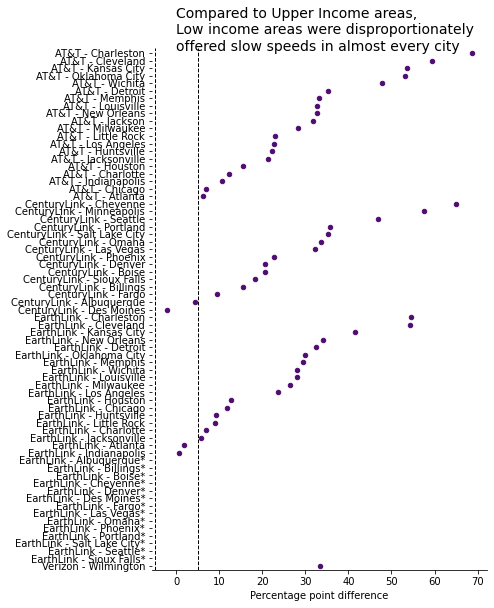

In [27]:
plot_observed(table, iv='income', fn=fn_observed_income,
              ylim=68.5,
              title = "Compared to Upper Income areas,\nLow income areas were disproportionately\noffered slow speeds in almost every city",)

<ipython-input-26-82947ed3bfba>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


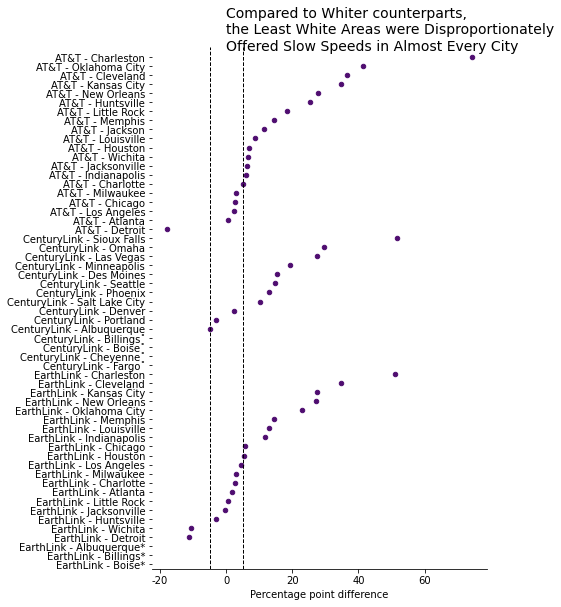

In [28]:
plot_observed(table, iv='race', fn=fn_observed_race, ylim=56.5,
              title = f"Compared to Whiter counterparts,\nthe Least White Areas were Disproportionately\nOffered Slow Speeds in Almost Every City")

<ipython-input-26-82947ed3bfba>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


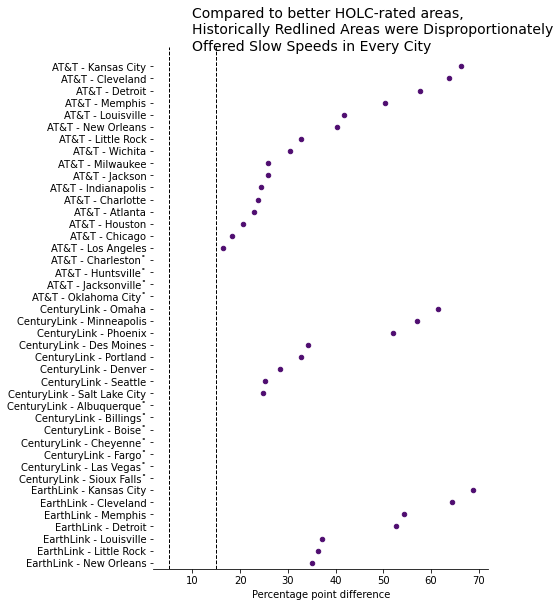

In [29]:
plot_observed(table, iv='redlining', fn=fn_observed_redlining, ylim=41.5,
              title = f"Compared to better HOLC-rated areas,\nHistorically Redlined Areas were Disproportionately\nOffered Slow Speeds in Every City",
)

## Regression

In [30]:
def preprocess_for_log_reg(df):
    df['n_providers'] = df['n_providers'] - 1
    df['income_dollars_below_median'] = df['income_dollars_below_median'] / 100

    df['constant'] = 1
    scaler = StandardScaler()
    df['lat_standard'] = scaler.fit_transform(df[['lat']])[:, 0]
    scaler = StandardScaler()
    df['lon_standard'] = scaler.fit_transform(df[['lon']])[:, 0]
    scaler = StandardScaler()
    df['ppl_per_sq_mile_standard'] = scaler.fit_transform(df[['ppl_per_sq_mile']])[:, 0]
    scaler = StandardScaler()
    df['income_dollars_below_median'] = scaler.fit_transform(df[['income_dollars_below_median']])[:, 0]
    
    # if there are no competitors, make this variable null.
    # Then this variable is linked to the outcome.
    df.loc[df.n_providers < 1, 'internet_perc_broadband'] = None
    
    scaler = StandardScaler()
    df['internet_perc_broadband'] = scaler.fit_transform(df[['internet_perc_broadband']])[:, 0]

    # this is our DV
    df['is_slow'] = df.apply(
        lambda x: 1 if x['speed_down_bins'] == "Slow (<25 Mbps)" else 0, 
        axis=1
    )
    
    for iv in ['income_level', 'race_quantile', 'redlining_grade']:
        df[iv] = df[iv].apply(lambda x: grade2rest.get(x, x))
    return df  

In [31]:
def train_and_return_coefs(formula, df, city, isp, model_name):
    """
    Workflow for fitting binary logistic regression for `formula`.
    This is formatted strangely because it'll be called by multiprocess(ing).Pool.
    """
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    import pandas as pd
    import numpy as np
    try:
        results = smf.logit(formula=formula, data=df).fit(disp=0)
        coefs = pd.DataFrame({
            'coef': results.params.values,
            'odds_ratio': np.exp(results.params.values),
            'pvalue': results.pvalues,
            'pr_sq': results.prsquared,
            'N' : len(df),
            'major_city': city,
            'state' : df.state.iloc[0],
            'isp': isp,
            'model' : model_name,
            'intercept': results.params['Intercept'],
        })
    except Exception as e:
        coefs = pd.DataFrame([{
            'N' : len(df),
            'major_city': city,
            'state' : df.state.iloc[0],
            'isp': isp,
            'model' : model_name,
            'error': e
        }])
    
    return coefs

In [32]:
def odds_to_probability(row, step=1):
    """
    See about this equation here:
    http://faculty.cas.usf.edu/mbrannick/regression/Logistic.html
    """
    a = row['intercept']
    b = row['coef']
    X = step
    try:
        return math.exp(a + b * X) / (1 + math.exp(a + b * X))
    except:
        return None

In [33]:
iv2treatment = {
    "income_level" : 'Upper Income',
    "race_quantile" : 'most white',
    "redlining_grade" : 'rest'
}

grade2rest = {
    'A' : 'rest',
    'B' : 'rest',
}

In [34]:
if not os.path.exists(fn_regression_all) or recalculate:
    data_regression = pd.DataFrame([])
    
    args = []
    for isp, fn in inputs.items():
        df = filter_df(fn, isp)
        df['major_city'] = df['major_city'].apply(lambda x: x.title())
        for (city, state), _df in df.groupby(by=['major_city', 'state']):
            _df = bucket_and_bin(_df)
            _df = preprocess_for_log_reg(_df)
            
            n_slow = len(_df[_df.speed_down_bins == 'Slow (<25 Mbps)'])
            n_not_slow = len(_df[_df.speed_down_bins != 'Slow (<25 Mbps)'])
            n_all = len(_df)
            if (_df.speed_down_bins.nunique() <= 1) or (n_slow / n_all <= .01) or (n_not_slow / n_all <= .01):
                # not enough speed
                continue
            for iv, treatment in iv2treatment.items():
                if iv == 'race_quantile':
                    n_minority_white = len(_df[_df.race_perc_non_white > .5])            
                    # check only cities with at least 5 percent of addresses in minority white.
                    if n_minority_white / len(_df) <= .05:
                        print(f"skip {city} {isp}")
                        continue
                elif iv == 'redlining_grade':
                    _df_rated = _df[~_df.redlining_grade.isnull()]
                    if len(_df_rated) <= len(_df) * .05:
                        continue
                    if 'D' not in _df['redlining_grade'].unique().tolist():
                        continue
                formula = f"is_slow ~ C({iv}, Treatment('{treatment}'))"
                args.append([formula, _df, city, isp, f"{iv}_alone"])
                if city != 'Wilmington':
                    formula += (" + ppl_per_sq_mile_standard + n_providers + internet_perc_broadband")
                else:
                    formula += (" + ppl_per_sq_mile_standard"
                                " + internet_perc_broadband")
                args.append([formula, _df, city, isp, f"{iv}_controls"])


                args.append([formula, _df, city, isp, f"{iv}_controls"])

                # ablation formulas
                if city != 'Wilmington':
                    formulas = [" + ppl_per_sq_mile_standard" , " + n_providers ", 
                                " + internet_perc_broadband"]
                else:
                    formulas = [" + ppl_per_sq_mile_standard" , " + n_providers "]
                for iv_ in formulas:
                    formula = f"is_slow ~ C({iv}, Treatment('{treatment}'))"
                    formula += "".join([f for f in formulas if f != iv_])
                    model_name =  f"{iv}_minus{iv_.replace(' + ', '_')}"
                    args.append([formula, _df, city, isp, model_name])

    with multiprocess.get_context("spawn").Pool(n_jobs) as pool:
        for coefs in tqdm(pool.istarmap(train_and_return_coefs, args), 
                           total=len(args)):
            data_regression = data_regression.append(coefs)

    # treatment group IE upper income, most white, best graded
    data_regression['probability_treatment'] = data_regression.apply(odds_to_probability, step=0, axis=1)
    # exposure group IE lower income, least white, redlined
    data_regression['probability_exposure'] = data_regression.apply(odds_to_probability, step=1, axis=1)
    data_regression['odds_directional'] = data_regression.apply(lambda x: x['odds_ratio'] * -1 if x['coef'] <0 else  x['odds_ratio'], axis=1)
    data_regression['is_coef_positive'] = data_regression.coef > 0
    # positive if exposure group has higher liklihood of slower speeds than treatment group
    data_regression['probability_delta'] = data_regression['probability_exposure'] - data_regression['probability_treatment']
    data_regression['perc_probability'] =  data_regression['probability_exposure'] / data_regression['probability_treatment']
    data_regression = data_regression[data_regression.index != 'Intercept']

    data_regression.to_csv(fn_regression_all)
    controls = data_regression[data_regression.model.str.contains('_controls')]
    controls.loc["C(income_level, Treatment('Upper Income'))[T.Low]"].to_csv(fn_regression_income)
    controls.loc["C(race_quantile, Treatment('most white'))[T.least white]"].to_csv(fn_regression_race)
    controls.loc["C(redlining_grade, Treatment('rest'))[T.D]"].to_csv(fn_regression_redlining)
    
else:
    data_regression = pd.read_csv(fn_regression_all, index_col=0)

In [35]:
len(set(data_regression[~data_regression.coef.isnull()].major_city.unique()))

41

## Ablation

In [36]:
# mean psuedo r-squared (goodness of fit) for each model across cities and ISPs.
for model, _df in data_regression.groupby(['model']):
    mean_pr = _df.groupby(['major_city', 'state', 'isp']).first().pr_sq.mean()
    print(model, mean_pr)

income_level_alone 0.04887890857768298
income_level_controls 0.09039024441199615
income_level_minus_internet_perc_broadband 0.08166644927365034
income_level_minus_n_providers  0.07929511155905314
income_level_minus_ppl_per_sq_mile_standard 0.07006459596963158
race_quantile_alone 0.02610591929259329
race_quantile_controls 0.08458929126236922
race_quantile_minus_internet_perc_broadband 0.062129862823578644
race_quantile_minus_n_providers  0.07342685803670776
race_quantile_minus_ppl_per_sq_mile_standard 0.060856791648833154
redlining_grade_alone 0.06403845085385915
redlining_grade_controls 0.1353100539645195
redlining_grade_minus_internet_perc_broadband 0.11885953708671704
redlining_grade_minus_n_providers  0.11005463543542665
redlining_grade_minus_ppl_per_sq_mile_standard 0.10782147951834761


The ablated IV that results in the least change from the observed are the most influential.

In [37]:
income_ablation = data_regression[
    (data_regression['model'].str.contains('income_level_minus_')) &
    (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
].merge(table, on=['isp', 'major_city', 'state'])
income_ablation['delta'] = abs(income_ablation['probability_delta'] - income_ablation['prop_slow_income_delta'])
income_ablation.sort_values(by='delta', ascending=True).groupby('major_city').first().model.value_counts(normalize=True)

income_level_minus_internet_perc_broadband     0.487805
income_level_minus_n_providers                 0.341463
income_level_minus_ppl_per_sq_mile_standard    0.170732
Name: model, dtype: float64

In [38]:
race_ablation = data_regression[
    (data_regression['model'].str.contains('race_quantile_minus_')) &
    (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
].merge(table, on=['isp', 'major_city', 'state'])
race_ablation['delta'] = abs(race_ablation['probability_delta'] - race_ablation['prop_slow_race_delta'])
race_ablation.sort_values(by='delta', ascending=True).groupby('major_city').first().model.value_counts(normalize=True)

race_quantile_minus_internet_perc_broadband     0.486486
race_quantile_minus_ppl_per_sq_mile_standard    0.297297
race_quantile_minus_n_providers                 0.216216
Name: model, dtype: float64

In [39]:
redlining_ablation = data_regression[
    (data_regression['model'].str.contains('redlining_grade_minus_')) &
    (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
].merge(table, on=['isp', 'major_city', 'state'])
redlining_ablation['delta'] = abs(redlining_ablation['probability_delta'] - redlining_ablation['prop_slow_redlining_delta'])
redlining_ablation.sort_values(by='delta', ascending=False).groupby('major_city').first().model.value_counts(normalize=True)

redlining_grade_minus_ppl_per_sq_mile_standard    0.518519
redlining_grade_minus_internet_perc_broadband     0.333333
redlining_grade_minus_n_providers                 0.148148
Name: model, dtype: float64

## Where to disparities persist?

In [40]:
income = (
    data_regression[
        (data_regression.model == f'income_level_controls') &
        (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
    ].sort_values('coef', ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'income_level_alone') &
            (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
income = income[income.major_city.isin(income_cities)]

race = (
    data_regression[
        (data_regression.model == f'race_quantile_controls') &
        (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
    ].sort_values(['coef', 'state'], ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'race_quantile_alone') &
            (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
race = race[race.major_city.isin(race_cities)]

redlining = (
    data_regression[
        (data_regression.model == f'redlining_grade_controls') &
        (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
    ].sort_values('coef', ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'redlining_grade_alone') &
            (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
redlining = redlining[redlining.major_city.isin(redlining_cities)]

In [41]:
threshold = 1
sig_income = income[income.pvalue < threshold]
slowest_income = sig_income[sig_income.probability_delta > 0.0]

sig_race = race[race.pvalue < threshold]
slowest_race = sig_race[sig_race.probability_delta > 0.0]

sig_redlining = redlining[redlining.pvalue < threshold]
slowest_redlining = sig_redlining[sig_redlining.probability_delta > 0.0]

print(f"Income ({len(sig_income)} city-ISP pairs)"
     f"\n- low income areas recieve greater proprotion of slow speeds in {len(slowest_income)} city-ISP pairs, or {len(slowest_income) / len(sig_income) * 100:.1f}% of cases.\n"
     f"- same pattern in {sig_income[sig_income.probability_delta > 0.0].major_city.nunique()} out of {sig_income.major_city.nunique()} cities ({sig_income[sig_income.probability_delta > 0.0].major_city.nunique() / sig_income.major_city.nunique():.2f}%)")
print(f"Race and Ethnicity ({len(sig_race)} city-ISP pairs)"
     f"\n- least white areas recieve greater proportion of slow speeds in {len(slowest_race)} city-ISP pairs, or {len(slowest_race) / len(sig_race) * 100:.1f}% of cases.\n"
     f"- same pattern in {sig_race[sig_race.probability_delta > 0.0].major_city.nunique()} out of {sig_race.major_city.nunique()} cities ({sig_race[sig_race.probability_delta > 0.0].major_city.nunique() / sig_race.major_city.nunique():.2f}%)")

print(f"Redlining ({len(sig_redlining)} city-ISP pairs)"
     f"\n- hazardous areas recieve greater proprotion of slow speeds in {len(slowest_redlining)} city-ISP pairs, or {len(slowest_redlining) / len(sig_redlining) * 100:.1f}% of cases.\n"
     f"- same pattern in {sig_redlining[sig_redlining.probability_delta > 0.0].major_city.nunique()} out of {sig_redlining.major_city.nunique()} cities ({sig_redlining[sig_redlining.probability_delta > 0.0].major_city.nunique() / sig_redlining.major_city.nunique():.2f}%)")


Income (59 city-ISP pairs)
- low income areas recieve greater proprotion of slow speeds in 56 city-ISP pairs, or 94.9% of cases.
- same pattern in 36 out of 39 cities (0.92%)
Race and Ethnicity (54 city-ISP pairs)
- least white areas recieve greater proportion of slow speeds in 33 city-ISP pairs, or 61.1% of cases.
- same pattern in 21 out of 34 cities (0.62%)
Redlining (38 city-ISP pairs)
- hazardous areas recieve greater proprotion of slow speeds in 36 city-ISP pairs, or 94.7% of cases.
- same pattern in 22 out of 23 cities (0.96%)


In [42]:
trend = set(sig_income.major_city.unique().tolist() + sig_race.major_city.unique().tolist() + sig_redlining.major_city.unique().tolist())
all_cities = set(income.major_city.unique().tolist() + race.major_city.unique().tolist() + redlining.major_city.unique().tolist())
cities = set(data_regression.major_city.unique())
len(all_cities)
all_cities - trend

set()

In [43]:
len(income[income.pvalue < .05]) / len(income)

0.9152542372881356

In [44]:
income.pr_sq.describe()

count    59.000000
mean      0.087737
std       0.062408
min       0.009754
25%       0.045964
50%       0.070327
75%       0.116465
max       0.294234
Name: pr_sq, dtype: float64

In [45]:
income.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

True     0.898305
False    0.101695
Name: odds_ratio, dtype: float64

In [46]:
len(race[race.pvalue < .05]) / len(race)

0.7962962962962963

In [47]:
race.pr_sq.describe()

count    54.000000
mean      0.082345
std       0.063269
min       0.015261
25%       0.041760
50%       0.068599
75%       0.095457
max       0.362669
Name: pr_sq, dtype: float64

In [48]:
race.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

False    0.574074
True     0.425926
Name: odds_ratio, dtype: float64

In [49]:
len(redlining[redlining.pvalue < .05]) / len(redlining)

0.8947368421052632

In [50]:
redlining.pr_sq.describe()

count    38.000000
mean      0.132785
std       0.065974
min       0.033574
25%       0.068330
50%       0.135508
75%       0.177962
max       0.321479
Name: pr_sq, dtype: float64

In [51]:
redlining.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

True     0.868421
False    0.131579
Name: odds_ratio, dtype: float64

See the factor that lead to the greatest adjustments for any city

In [52]:
income_ablation_ = data_regression[
    (data_regression['major_city'] == 'Seattle') &
    (data_regression['model'].str.contains('income_level_minus_')) & 
    (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
].merge(table, on=['isp', 'major_city', 'state'])
income_ablation_['delta'] = abs(income_ablation_['probability_delta'] - 
                                income_ablation_['prop_slow_income_delta'])
income_ablation_.sort_values(by='delta', ascending=True)

,coef,odds_ratio,pvalue,pr_sq,N,major_city,state,isp,model,intercept,...,prop_slow_race_treatment,prop_slow_race_delta,flag_y,slowest_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta,flag,Observed,delta
1,1.167063,3.212542,1.515659e-37,0.200791,17938,Seattle,WA,CenturyLink,income_level_minus_n_providers,-1.286650,...,0.182344,0.148784,NaN,True,0.315002,0.1619,0.153102,NaN,0.153102,0.214622
0,2.046829,7.743309,1.242559e-139,0.139531,17938,Seattle,WA,CenturyLink,income_level_minus_ppl_per_sq_mile_standard,-3.319277,...,0.182344,0.148784,NaN,True,0.315002,0.1619,0.153102,NaN,0.153102,0.284418
2,0.829059,2.291162,1.466730e-27,0.227680,17938,Seattle,WA,CenturyLink,income_level_minus_internet_perc_broadband,-2.597803,...,0.182344,0.148784,NaN,True,0.315002,0.1619,0.153102,NaN,0.153102,0.391922


In [53]:
race_ablation_ = data_regression[
    (data_regression['major_city'] == 'Charleston') &
    (data_regression['model'].str.contains('race_quantile_minus_')) &
    (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
].merge(table, on=['isp', 'major_city', 'state'])
race_ablation_['delta'] = abs(race_ablation_['probability_delta'] - 
                              race_ablation_['prop_slow_income_delta'])
race_ablation_.sort_values(by='delta', ascending=True)

,coef,odds_ratio,pvalue,pr_sq,N,major_city,state,isp,model,intercept,...,prop_slow_race_treatment,prop_slow_race_delta,flag_y,slowest_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta,flag,Observed,delta
3,0.386804,1.472268,0.006016,0.054457,3132,Charleston,SC,EarthLink,race_quantile_minus_ppl_per_sq_mile_standard,1.263766,...,0.262836,0.509891,NaN,NaN,NaN,NaN,NaN,not HOLC graded,NaN,0.486884
5,0.204757,1.227227,0.083041,0.092394,3132,Charleston,SC,EarthLink,race_quantile_minus_internet_perc_broadband,-0.392956,...,0.262836,0.509891,NaN,NaN,NaN,NaN,NaN,not HOLC graded,NaN,0.496096
4,-0.003327,0.996679,0.981969,0.092756,3132,Charleston,SC,EarthLink,race_quantile_minus_n_providers,-0.815833,...,0.262836,0.509891,NaN,NaN,NaN,NaN,NaN,not HOLC graded,NaN,0.546885
2,0.329635,1.390461,0.008640,0.202803,3849,Charleston,SC,AT&T,race_quantile_minus_internet_perc_broadband,0.505726,...,0.150845,0.742489,NaN,NaN,NaN,NaN,NaN,not HOLC graded,NaN,0.612947
0,0.297846,1.346954,0.058793,0.159984,3849,Charleston,SC,AT&T,race_quantile_minus_ppl_per_sq_mile_standard,2.491379,...,0.150845,0.742489,NaN,NaN,NaN,NaN,NaN,not HOLC graded,NaN,0.668075
1,-0.349458,0.705070,0.034411,0.196681,3849,Charleston,SC,AT&T,race_quantile_minus_n_providers,-1.249748,...,0.150845,0.742489,NaN,NaN,NaN,NaN,NaN,not HOLC graded,NaN,0.741282


In [54]:
redlining_ablation_ = data_regression[
    (data_regression['major_city'] == 'Los Angeles') &
    (data_regression['model'].str.contains('redlining_grade_minus_')) &
    (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
].merge(table, on=['isp', 'major_city', 'state'])
redlining_ablation_['delta'] = abs(redlining_ablation_['probability_delta'] - 
                                  redlining_ablation_['prop_slow_income_delta'])
redlining_ablation_.sort_values(by='delta', ascending=True)

,coef,odds_ratio,pvalue,pr_sq,N,major_city,state,isp,model,intercept,...,prop_slow_race_treatment,prop_slow_race_delta,flag_y,slowest_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta,flag,Observed,delta
3,0.317112,1.373156,7.720159e-12,0.038610,30510,Los Angeles,CA,EarthLink,redlining_grade_minus_ppl_per_sq_mile_standard,-2.152957,...,0.279305,0.045272,NaN,True,0.335094,0.254956,0.080139,NaN,0.080139,0.203251
0,0.186851,1.205448,1.366291e-05,0.033296,35347,Los Angeles,CA,AT&T,redlining_grade_minus_ppl_per_sq_mile_standard,-1.909801,...,0.315390,0.022809,NaN,True,0.335247,0.270407,0.064840,NaN,0.064840,0.204356
2,0.123821,1.131814,3.159975e-03,0.047557,35347,Los Angeles,CA,AT&T,redlining_grade_minus_internet_perc_broadband,-1.713396,...,0.315390,0.022809,NaN,True,0.335247,0.270407,0.064840,NaN,0.064840,0.210124
5,0.215225,1.240141,2.243719e-06,0.054355,30510,Los Angeles,CA,EarthLink,redlining_grade_minus_internet_perc_broadband,-1.978241,...,0.279305,0.045272,NaN,True,0.335094,0.254956,0.080139,NaN,0.080139,0.211833
4,0.075019,1.077905,1.053581e-01,0.025262,30510,Los Angeles,CA,EarthLink,redlining_grade_minus_n_providers,-0.847874,...,0.279305,0.045272,NaN,True,0.335094,0.254956,0.080139,NaN,0.080139,0.220756
1,-0.026844,0.973513,5.330861e-01,0.026194,35347,Los Angeles,CA,AT&T,redlining_grade_minus_n_providers,-0.743143,...,0.315390,0.022809,NaN,True,0.335247,0.270407,0.064840,NaN,0.064840,0.232680


## Plots with Adjustments

In [55]:
label2marker = {
    'Observed': 'o',
    'Adjusted': '^'
}

In [56]:
def plot_adjusted(to_plot, ylim=33.5, figsize=(6, 8), fn=fn_adjusted_redlining,
                  title= f"After adjusting for other factors, Redlined areas\nstill disprportionately offered slow Internet speeds",
                  title_y = -3.2, title_x= -.05):
    legend_elements = [Line2D([0], [0], marker=label2marker.get(label), color='w', 
                          label=label, markerfacecolor=c, markersize=10)
                   for label, c in {'Observed': color_1, 'Adjusted': color_2}.items()][::-1] 
    
    to_plot_ = to_plot#[(to_plot['pvalue'] < 0.05)]
    to_plot_['major_city_isp'] = to_plot_.apply(lambda x: x['isp'] + ' - ' + x['major_city'], axis=1)

    to_plot_['Observed'] = to_plot_.probability_delta_alone * 100
    to_plot_['Adjusted'] = to_plot_.probability_delta * 100

    to_plot_ = to_plot_.sort_values(by=['Adjusted', 'state', 'Observed'], ascending=False)

    ax = to_plot_.plot(y='major_city_isp', x='Observed', 
                      color=color_1,
                      kind='scatter', figsize=figsize)
    to_plot_.plot(y='major_city_isp', x='Adjusted', 
                 color=color_2, ax=ax, marker='^',
                 alpha = [bool2alpha.get(_) for _ in to_plot_.pvalue < 0.05],
                 kind='scatter')

    x1 = to_plot_['Adjusted'].tolist()
    x2 = to_plot_['Observed'].tolist()
    n = to_plot_['major_city_isp'].tolist()
    for i in range(0, len(x1)):
        ax.plot([x1[i], x2[i]], [n[i], n[i]], '-', 
                color='black', zorder=-1, alpha=.8)

    to_plot_['isp'] = pd.Categorical(to_plot_['isp'], ["AT&T", "Verizon", "CenturyLink", "EarthLink"])
    to_plot_ = to_plot_.sort_values(by=['isp','Adjusted', 'state', 'Observed'], 
                                    ascending=[True, False, False, False])
    to_plot_[['major_city', 'isp', 'Adjusted', 'Observed', 'state']].to_csv(fn, index=False)    

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.gca().invert_yaxis()

    ax.set_ylabel("")
    labels = ax.get_xticks().tolist()
    labels = [int(_) for _ in labels]
    # labels[0] = "0%"
    ax.set_xticklabels(labels)
    ax.set_xlabel("Percentage point difference")
    # ax.get_legend().remove()

    plt.axvline(x=0,linewidth=1, color='black', linestyle='--', ymax=.96)

    plt.text(title_x, title_y, 
             title,
             size=14,
             horizontalalignment='left',
             verticalalignment='center',);
    ax.set_ylim(bottom=ylim)

    ax.legend(handles=legend_elements[::-1],
                  loc='lower left', 
                  bbox_to_anchor= (-0.025, .97), 
                  ncol=5,
                  handletextpad=0.0,
                  labelspacing=0, 
                  borderaxespad=.1, 
                  borderpad=0.1,
                  frameon=False,
                  prop={'size': 9.2})

<ipython-input-56-566b5340089f>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


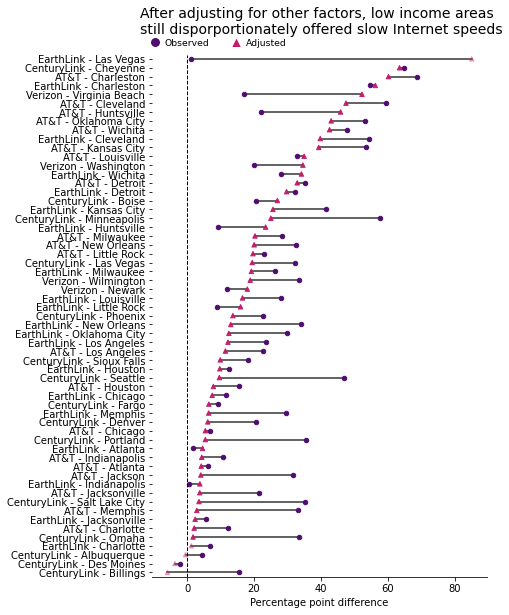

In [64]:
to_plot = income
plot_adjusted(to_plot, ylim=58.5, figsize=(6, 10), 
              fn=fn_adjusted_income,
              title_y = -4.2, title_x = -14, 
              title= f"After adjusting for other factors, low income areas\nstill disporportionately offered slow Internet speeds",
)

<ipython-input-56-566b5340089f>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


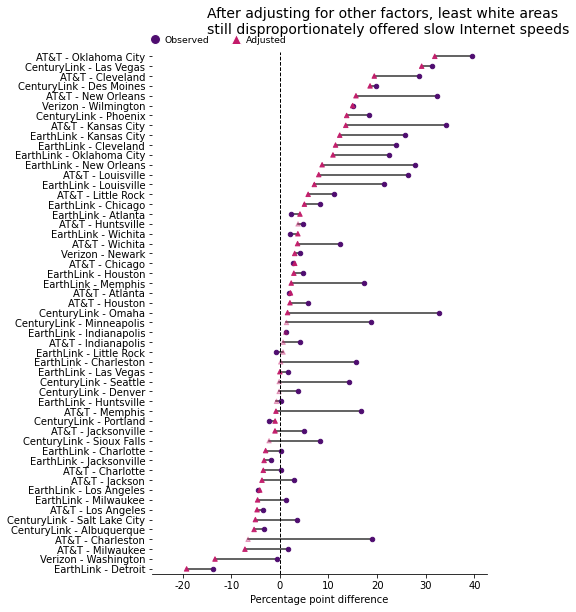

In [65]:
to_plot = race
plot_adjusted(to_plot, ylim=52.5, figsize=(6, 10), 
              fn=fn_adjusted_race,
              title_y = -3.5, title_x = -15,
              title= f"After adjusting for other factors, least white areas\nstill disproportionately offered slow Internet speeds",
)

<ipython-input-56-566b5340089f>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


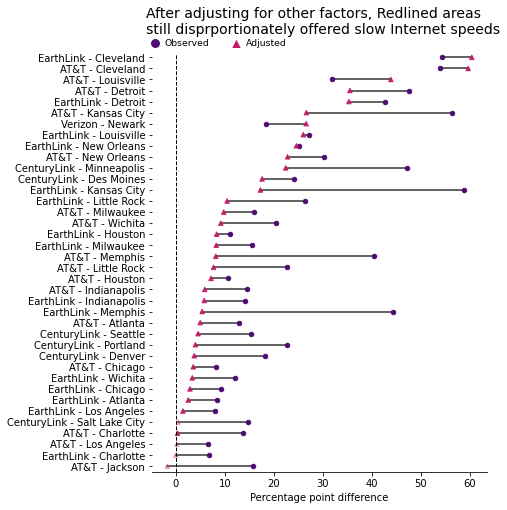

In [62]:
to_plot = redlining
plot_adjusted(to_plot, title_y=-3.2, title_x=-6, ylim=37.5, fn=fn_adjusted_redlining)